# Homework

In [1]:
import os
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    import requests

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

## Q1. Downloading the data

Download the data (**Yellow** Taxi Trip Records) for January and February 2023 ([NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page))

In [2]:
def download_file(url, directory):
    response = requests.get(url)
    filename = os.path.join(directory, url.split("/")[-1])
    with open(filename, 'wb') as f:
        f.write(response.content)
    return filename

In [3]:
DATA_FOLDER = "./data"

datasets = [
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet",
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet"
]

for dataset in datasets:
    filename = os.path.join(DATA_FOLDER, dataset.split("/")[-1])
    if not os.path.exists(filename):
        download_file(dataset, DATA_FOLDER)

Read the data for January. How many columns are there?

In [4]:
df = pd.read_parquet("./data/yellow_tripdata_2023-01.parquet")
print(f"Number of columns: {len(df.columns)}")

Number of columns: 19


## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes.

In [5]:
df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration'] = df['duration'].dt.total_seconds() / 60

What's the standard deviation of the trips duration in January?

In [6]:
print(f"Standard deviation of trip duration: {df['duration'].std():.2f} minutes")

Standard deviation of trip duration: 42.59 minutes


## Q3. Dropping outliers

Check the distribution of the `duration` variable. There are some outliers.

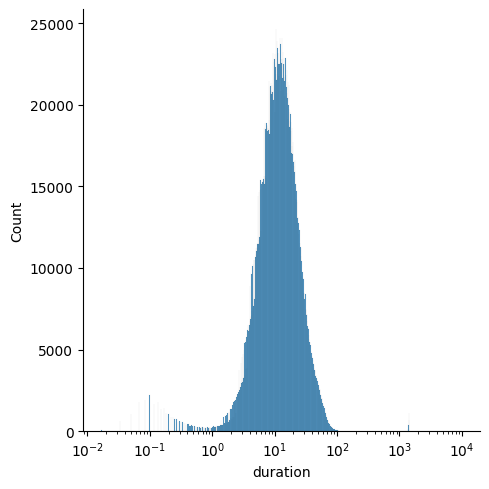

In [7]:
sns.displot(df['duration'], log_scale=True);

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive). What fraction of the records left after you dropped the outliers?

In [8]:
n_entries_raw_dataset = len(df)
df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
print(f"Fraction of records left after dropping outliers: {len(df) / n_entries_raw_dataset:.0%}")

Fraction of records left after dropping outliers: 98%


## Q4. One-hot encoding

Turn the dataframe into a list of dictionaries

In [9]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical + numerical].to_dict(orient='records')

Fit a dictionary vectorizer and get a feature matrix from it. What's the dimensionality of this matrix (number of columns)?

In [10]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
print(f"Number of columns: {X_train.shape[1]}")

Number of columns: 516


## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. Train a plain linear regression model with default parameters.

In [11]:
y_train = df['duration'].values

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

Calculate the RMSE of the model on the training data. What's the RMSE on train?

In [12]:
y_pred = lr.predict(X_train)
print(f"Training RMSE: {root_mean_squared_error(y_train, y_pred):.2f} minutes")

Training RMSE: 7.66 minutes


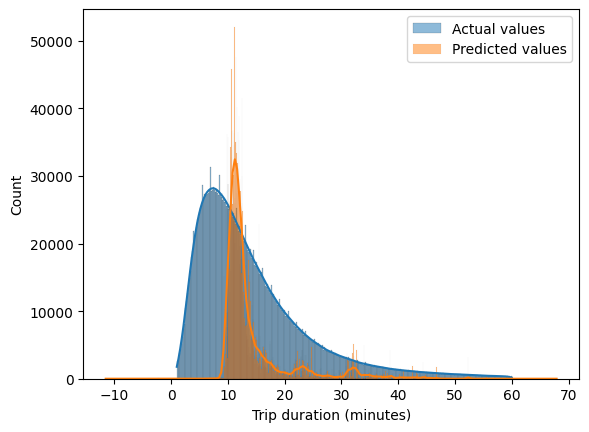

In [13]:
sns.histplot(y_train, label='Actual values', kde=True, alpha=0.5)
sns.histplot(y_pred, label='Predicted values', kde=True, alpha=0.5)
plt.xlabel('Trip duration (minutes)')
plt.legend()
plt.show()

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (February 2022). 

In [14]:
# Utiliy function to implement the above code for any given file
def import_dataset(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration'] = df['duration'].dt.total_seconds() / 60

    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [15]:
df_val = import_dataset("./data/yellow_tripdata_2023-02.parquet")
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

What's the RMSE on validation?

In [16]:
y_val = df_val['duration'].values
y_pred = lr.predict(X_val)
print(f"Validation RMSE: {root_mean_squared_error(y_val, y_pred):.2f} minutes")

Validation RMSE: 7.82 minutes
